# Buy-and-Hold Portfolio

Academic/educational purposes only.  For me to practice coding.

## 60/40 S&P ETF and Total Bond ETF (Vanguard ETFs)

Hypothetical growth of a \$10k portfolio (300 per month), with DCA 60/40 allocation strategy versus a lump sum 60/40 allocation strategy, all measured against the ^GSPC ticker.  

The VOO ticker symbol is the Vanguard S&P 500 ETF (which tracks the S&P 500 index), and BND is the ticker for the Vnaguard Total Bond Market ETF which tracks the Bloomberg Barclays U.S. Aggregate Float Adjusted Index (which in turn holds a wide spectrum of fixed income securities).  

Allocation is 60/40 across entire time series, assumes automatic daily rebalancing (assuming fractional shares can be bought and sold) and start date is 2016-01-01

In [28]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date
from scipy.stats.mstats import gmean

### Data imports

In [29]:
voo = web.DataReader('VOO', 'yahoo', start='2016-01-01', end= date.today())
bnd = web.DataReader('BND','yahoo', start = '2016-01-01', end = date.today())
gspc = web.DataReader('^GSPC','yahoo', start = '2016-01-01', end = date.today())

In [30]:
voo_returns = voo.shift(-1)["Close"]/voo["Close"] - 1
bnd_returns = bnd.shift(-1)["Close"]/bnd["Close"] - 1
gspc_returns = gspc.shift(-1)["Close"]/gspc["Close"] - 1

In [31]:
voo_returns.dropna(inplace = True)
bnd_returns.dropna(inplace = True)
gspc_returns.dropna(inplace = True)

### DCA

Invest 300 on the first day of every month, until cash = 0.  The periodic payment was chosen for the purposes of being fully invested by the end of the 5-year timeline.

In [32]:
portfolio_value = 10000
current_investment = 300

portfolio_value -= current_investment
dca_time_series = []

for i in range(0,len(voo_returns)):
    
    if voo_returns.index[i].day == 1 and portfolio_value >= 300:
        current_investment += 300
        portfolio_value -= 300
    elif portfolio_value < 300:
        current_investment += portfolio_value
        portfolio_value = 0
    current_investment *= 1 + voo_returns[i]*0.6 + bnd_returns[i]*0.4
    
    total = portfolio_value + current_investment
    dca_time_series.append(total)

### Lump Sum and Benchmark

We do a lump sum strategy in the 60/40 as well as a 100% allocation in ^GSPC

In [33]:
portfolio_value = 10000
ls_time_series = []

for i in range(0,len(voo_returns)):
    portfolio_value *= 1 + voo_returns.iloc[i]*0.6 + bnd_returns.iloc[i]*0.4
    ls_time_series.append(portfolio_value)

In [34]:
portfolio_value = 10000
gspc_time_series = []

for i in range(0,len(gspc_returns)):
    portfolio_value *= 1 + gspc_returns.iloc[i]
    gspc_time_series.append(portfolio_value)

### Visualizations

Clearly, having a 100% allocation in the S&P 500 is preferable for the return-maximizing investor.  However, the 60/40 allocation strategies do not exhibit as much volatility, which would be helpful for investors that are looking to minimize downside risks.

In [35]:
sns.set_theme()

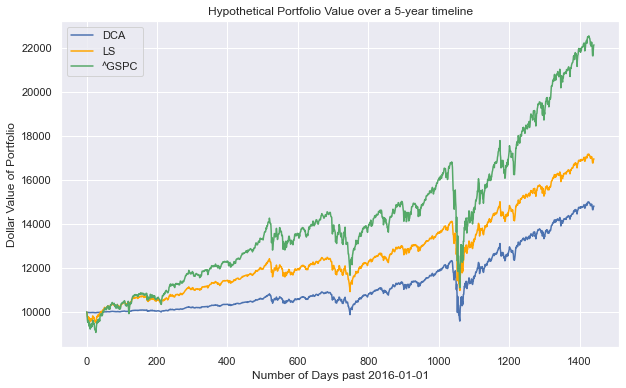

In [36]:
fig = plt.figure(figsize = (10,6))
plt.plot(dca_time_series, label = "DCA", color = "b")
plt.plot(ls_time_series, label = "LS", color = "orange")
plt.plot(gspc_time_series, label = "^GSPC", color = "g")
plt.legend()
plt.title("Hypothetical Portfolio Value over a 5-year timeline")
plt.ylabel("Dollar Value of Portfolio")
plt.xlabel("Number of Days past 2016-01-01")
plt.show()

In [37]:
dca_returns = [dca_time_series[value + 1]/dca_time_series[value] - 1 for value in range(0,len(dca_time_series)-1)]
ls_returns = [ls_time_series[value + 1]/ls_time_series[value] - 1 for value in range(0,len(ls_time_series)-1)]
gspc_returns = [gspc_time_series[value + 1]/gspc_time_series[value] - 1 for value in range(0,len(gspc_time_series)-1)]

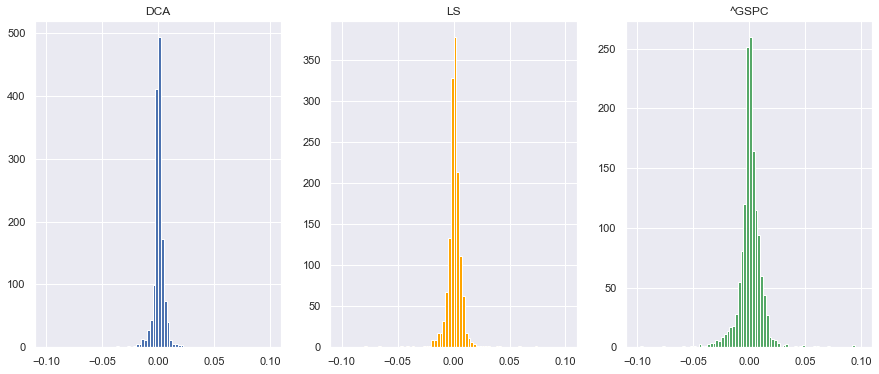

In [38]:
fig, axes = plt.subplots(1,3, figsize = (15,6))

axes[0].hist(dca_returns, range = (-0.1,0.1), bins = 80, color = "b")
axes[0].title.set_text("DCA")
axes[1].hist(ls_returns, range = (-0.1,0.1), bins = 80, color = "orange")
axes[1].title.set_text("LS")
axes[2].hist(gspc_returns, range = (-0.1,0.1), bins = 80, color = "g")
axes[2].title.set_text("^GSPC")
plt.show()

Based on the histograms above, we can see that for DCA and LS, the distributions are tighter with smaller tails, whereas the S&P 500 benchmark has larger tails.  The distributions are somewhat similar, which is expected since they mostly contain the same asset (the S&P 500 index).

### Comparisons

As expected, the 100% investment in the S&P 500 has the greatest return on an initial \$10k investment, outperforming the 60/40 portfolios.  However, the lower 5 pct tail of the distribution for the S&P 500 has a negative return nearly twice as large as that of the DCA and LS strategies.

In [39]:
# Percent change from the initial 10000 investment

dca_change = dca_time_series[len(dca_time_series)-1]/10000
ls_change = ls_time_series[len(ls_time_series)-1]/10000
gspc_change = gspc_time_series[len(gspc_time_series)-1]/10000

pd.Series([dca_change,ls_change,gspc_change], index = ["DCA","LS","^GSPC"])

DCA      1.481973
LS       1.696321
^GSPC    2.213727
dtype: float64

In [40]:
# Lower tail 5% quantile

dca_left_tail = np.quantile(dca_returns, 0.05)
ls_left_tail = np.quantile(ls_returns, 0.05)
gspc_left_tail = np.quantile(gspc_returns, 0.05)

pd.Series([dca_left_tail,ls_left_tail,gspc_left_tail], index = ["DCA","LS","^GSPC"])

DCA     -0.007560
LS      -0.009220
^GSPC   -0.016643
dtype: float64

The table below compares the standard deviation and geometric mean of returns for all strategies.  ^GSPC has the greatest standard deviation but the greatest gmean, followed by LS and then DCA.  Assuming a $r_f$ rate of 3%, we can find the annualized Sharpe Ratio (assuming 250 trading days a year).  **Note that Daily Standard Deviation and Average Daily Return have been converted into percentages, and are not in decimal form.**

In [42]:
dca_std = np.std(dca_returns)*100
ls_std = np.std(ls_returns)*100
gspc_std = np.std(gspc_returns)*100

dca_gmean = (gmean([1 + x for x in dca_returns]) - 1)*100
ls_gmean = (gmean([1 + x for x in ls_returns]) - 1)*100
gspc_gmean = (gmean([1 + x for x in gspc_returns]) - 1)*100

dca_SR = (dca_gmean*250 - 0.03)/(dca_std*np.sqrt(250))
ls_SR = (ls_gmean*250 - 0.03)/(ls_std*np.sqrt(250))
gspc_SR = (gspc_gmean*250 - 0.03)/(gspc_std*np.sqrt(250))

return_stats = pd.DataFrame(index=["DCA","LS","^GSPC"])
return_stats["Daily Standard Deviation"] = [dca_std, ls_std, gspc_std]
return_stats["Average Daily Return"] = [dca_gmean, ls_gmean, gspc_gmean]
return_stats["Annualized SR"] = [dca_SR, ls_SR, gspc_SR]
return_stats

,Daily Standard Deviation,Average Daily Return,Annualized SR
DCA,0.648651,0.027299,0.662513
LS,0.716693,0.036571,0.804169
^GSPC,1.166215,0.055023,0.744372


The Daily Standard Deviation for the S&P 500 can most likely be attributed to the recent bouts of volatility due to the global pandemic.

Based on the table above, doing a lump sum strategy with a 60/40 allocation provides the largest Sharpe Ratio.  In conclusion, the optimal strategy for an investor seeking to maximize their Sharpe Ratio (between these three strategies) would be to do a lump sum investemnt of a 60/40 stock-bond.